In [1]:
import numpy as np
import pandas as pd
import time
from matplotlib import pyplot as plt
%matplotlib inline

# from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedKFold
# from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve,auc

In [2]:
#parameters
in_file = '../../merge/reformatted_data_with_features.txt'
out_dir = 'TFBS_results'
metadata_file = '../../../../../metadata/MBC/merged_key_metadata.txt'
status_col = 'merged_updated_ER_status_binary'
n_iter = 1000

In [3]:
#import data
data = pd.read_csv(in_file, sep='\t')
data = data.set_index('sample')

#get features and exclude all other columns
features = data.columns[(data.columns.str.startswith('central_cov')) | (data.columns.str.startswith('mean_cov')) | (data.columns.str.startswith('fft_10_magnitude'))]
data = data[features]
print('features',len(features))

#get metadata
metadata = pd.read_csv(metadata_file, sep='\t')
metadata = metadata.set_index('sample')
data = data.merge(metadata, left_index=True, right_index=True)
data['status'] = np.where(data[status_col]=='+',1,0)

#filter data
min_tfx = 0.05
min_cov = 0.1

#training data
data = data[(data['tumor_fraction']>=min_tfx) & (data['ulp_wgs_coverage']>=min_cov)]
print('total',len(data))
print(data[status_col].value_counts())

high_tfx = data[(data['tumor_fraction']>=0.1) & (data['ulp_wgs_coverage']>=min_cov)]
print('high tfx',len(high_tfx))
print(high_tfx[status_col].value_counts())
del(high_tfx)

data = data.sort_index()

features 1014
total 254
+    132
-    122
Name: merged_updated_ER_status_binary, dtype: int64
high tfx 191
+    99
-    92
Name: merged_updated_ER_status_binary, dtype: int64


In [4]:
features

Index(['central_cov_AHR.hg38', 'central_cov_AR.hg38',
       'central_cov_ARID3A.hg38', 'central_cov_ARNT.hg38',
       'central_cov_ARNTL.hg38', 'central_cov_ASCL1.hg38',
       'central_cov_ASCL2.hg38', 'central_cov_ATF1.hg38',
       'central_cov_ATF2.hg38', 'central_cov_ATF3.hg38',
       ...
       'mean_cov_ZNF486.hg38', 'mean_cov_ZNF554.hg38', 'mean_cov_ZNF574.hg38',
       'mean_cov_ZNF580.hg38', 'mean_cov_ZNF652.hg38', 'mean_cov_ZNF770.hg38',
       'mean_cov_ZNF792.hg38', 'mean_cov_ZSCAN16.hg38',
       'mean_cov_ZSCAN22.hg38', 'mean_cov_ZSCAN9.hg38'],
      dtype='object', length=1014)

In [5]:
#view data
data.head()

,central_cov_AHR.hg38,central_cov_AR.hg38,central_cov_ARID3A.hg38,central_cov_ARNT.hg38,central_cov_ARNTL.hg38,central_cov_ASCL1.hg38,central_cov_ASCL2.hg38,central_cov_ATF1.hg38,central_cov_ATF2.hg38,central_cov_ATF3.hg38,...,merged_ER_switch,merged_updated_ER_status,merged_updated_ER_status_binary,merged_PrimaryProgesteroneStatus,merged_MetsProgesteroneStatus,merged_PR_switch,merged_TimeFromMet_ToDeathOrLastFU_Days,merged_DeathCensor,first_passing_sample,status
sample,,,,,,,,,,,,,,,,,,,,,
MBC_1041_1_ULP,0.939738,0.980202,0.935048,0.940685,1.077927,1.012933,0.872018,0.692708,0.925503,0.783452,...,same,+,+,-,+,gain,6746.0,1.0,1.0,1
MBC_1041_3_ULP,0.943930,0.952897,0.898685,0.945330,1.009032,1.045983,0.980058,0.738007,0.974135,0.802170,...,same,+,+,-,+,gain,6746.0,1.0,NaN,1
MBC_1041_4_ULP,0.904892,0.955568,0.959213,0.892250,0.989910,1.021387,0.940163,0.663435,1.022915,0.772770,...,same,+,+,-,+,gain,6746.0,1.0,NaN,1
MBC_1042_1_ULP,0.929905,0.970383,0.911963,0.829052,0.945632,1.023265,0.913467,0.669745,0.976888,0.789968,...,same,+,+,+,-,loss,2116.0,1.0,NaN,1
MBC_1042_2_ULP,0.812185,0.987232,0.945407,0.890898,0.962938,1.061150,0.890143,0.687457,0.961217,0.797125,...,same,+,+,+,-,loss,2116.0,1.0,1.0,1


In [6]:
#scale data
scaler = StandardScaler()
scaler.fit(data[features])
data[features] = scaler.transform(data[features])
data[features].mean()

central_cov_AHR.hg38       6.294178e-16
central_cov_AR.hg38        1.608512e-16
central_cov_ARID3A.hg38   -2.265904e-15
central_cov_ARNT.hg38     -1.902240e-15
central_cov_ARNTL.hg38     1.744886e-15
                               ...     
mean_cov_ZNF770.hg38       2.570123e-15
mean_cov_ZNF792.hg38       3.145341e-15
mean_cov_ZSCAN16.hg38     -1.236456e-14
mean_cov_ZSCAN22.hg38     -7.472588e-15
mean_cov_ZSCAN9.hg38      -8.220896e-15
Length: 1014, dtype: float64

In [7]:
#bootstrapping
hyperparameters = {'C': [0.00001, 0.0001, 0.001,0.01,0.1,1,10,100]}

start_time = time.time()

probabilities = pd.DataFrame(index=data.index)
c_vals = []
coefs = pd.DataFrame(index=features)

#loop for each iteration
countup = 0
for i in range(n_iter):
    if i%50==0:
        print(i,countup, time.time()-start_time)
    
    patients = pd.Series(data['patient_id'].unique())
    
    good_split = 0
    while good_split == 0:
        #bootstrap a training set with replacement
        training_ids = patients.sample(len(patients), replace = True, random_state = 100+countup)
                
        #get bootstrapped training set, if a patient ID is included in the training_ids set j times, include all samples from that patient j times
        training = pd.DataFrame()
        
        #group the training patient IDs by number of times they are observed in the bootstrapped training_ids
        for j,df in pd.DataFrame(training_ids.value_counts().rename('count')).groupby(by = 'count'):

            #identify the samples from this group of patients
            current_data = data[data['patient_id'].isin(df.index)]

            #copy the training samples so that they appear j times in training dataframe
            current_training = pd.DataFrame()
            for k in range(j):
                current_training = current_training.append(current_data)
            training = training.append(current_training)
        
        
        #the test set is all samples that aren't seen in the training data
        test = data[~(data.index.isin(training.index))]
        
        #check to make sure first time point low tumor fraction samples for both classes are included in the test set
        if len(test[(test['tumor_fraction']<.1) & (test['first_passing_sample']==1)]['status'].unique())!=2:
            print('skipping iteration',i)
            countup += 1
        else:
            good_split = 1
    
    #countup will get ahead of i if it has to skip bad train-test splits
    countup +=1
        
    #10 fold cross validation on the training set
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state =100+countup) 

    model = LogisticRegression(class_weight='balanced', max_iter=500)
    search = GridSearchCV(estimator=model, param_grid=hyperparameters, cv=cv, n_jobs = 1)
    search.fit(training[features], training['status'])
    best_C = search.best_params_['C']
    
    #train a new model on the full training dataset (is this the same as refit...?)
    model = LogisticRegression(class_weight='balanced', max_iter=500, C=best_C)
    model.fit(training[features], training['status'])

    #predict the test data
    pred = model.predict(test[features])
    prob = model.predict_proba(test[features])

    
    #collect metrics
    current_output = pd.DataFrame(test[['status']])#.reset_index()
    current_output['probability']=prob[:,1]
    current_output['prediction']=pred
    current_output['accuracy'] = np.where(current_output['prediction']==current_output['status'],1,0)    
    
    #save results
    probabilities[i] = current_output['probability']
    c_vals.append(best_C)
    coefs[i] = pd.Series(model.coef_[0], index = features)
    

probabilities = probabilities.merge(data[['status']], left_index=True, right_index=True)

0 0 0.0009629726409912109
50 50 52.588046073913574
100 100 103.97402787208557
150 150 155.36356902122498
200 200 208.81979274749756
250 250 260.5120539665222
300 300 310.7249987125397
350 350 363.96350502967834
400 400 416.2217388153076
450 450 469.77420687675476
500 500 522.7247519493103
550 550 576.9388258457184
600 600 628.0182938575745
650 650 678.5465009212494
700 700 729.6816387176514
skipping iteration 715
750 751 780.9684820175171
800 801 831.2773039340973
850 851 881.7733228206635
900 901 932.4462609291077
950 951 986.3558430671692


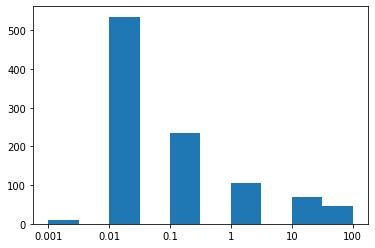

In [8]:
#export results
probabilities.to_csv(out_dir+'/probabilities.txt', sep='\t')
pd.Series(c_vals).to_csv(out_dir+'/c_values.txt', sep='\t', header = False, index=False)
coefs.to_csv(out_dir+'/coefs.txt', sep='\t')

plt.hist([str(m) for m in sorted(c_vals)])
plt.savefig(out_dir+'/cvals.pdf')

In [9]:
#print some key info

In [10]:
probabilities = probabilities.merge(data[['first_passing_sample','tumor_fraction']], left_index=True, right_index=True)

In [11]:
#high tfx per patient accuracy
accuracy = []
for i in range(n_iter):
    current = probabilities[~(probabilities[i].isnull())][[i,'status','tumor_fraction','first_passing_sample']]
    current = current[(current['tumor_fraction']>=0.1) & (current['first_passing_sample']==1)]
    accuracy.append(sum(np.round(current[i])==current['status'])/len(current))
    
np.mean(accuracy)

0.700937625520203

In [12]:
#per sample accuracy
accuracy = []
for i in range(n_iter):
    current = probabilities[~(probabilities[i].isnull())][[i,'status','tumor_fraction','first_passing_sample']]
    current = current[(current['tumor_fraction']>=0.1)]
    accuracy.append(sum(np.round(current[i])==current['status'])/len(current))
np.mean(accuracy)

0.7163149062036591

In [13]:
#low tfx per patient accuracy
accuracy = []
for i in range(n_iter):
    current = probabilities[~(probabilities[i].isnull())][[i,'status','tumor_fraction','first_passing_sample']]
    current = current[(current['tumor_fraction']<0.1) & (current['first_passing_sample']==1)]
    accuracy.append(sum(np.round(current[i])==current['status'])/len(current))
    
np.mean(accuracy)

0.6076577309464962

In [14]:
#per sample accuracy
accuracy = []
for i in range(n_iter):
    current = probabilities[~(probabilities[i].isnull())][[i,'status','tumor_fraction','first_passing_sample']]
    current = current[(current['tumor_fraction']<0.1)]
    accuracy.append(sum(np.round(current[i])==current['status'])/len(current))
np.mean(accuracy)

0.6164336539039259

In [15]:
#per patient accuracy for all samples
accuracy = []
for i in range(n_iter):
    current = probabilities[~(probabilities[i].isnull())][[i,'first_passing_sample','status']]
    current = current[(current['first_passing_sample']==1)]
    accuracy.append(sum(np.round(current[i])==current['status'])/len(current))
    
np.mean(accuracy)

0.6755323703989863

In [16]:
#per sample accuracy for all samples
accuracy = []
for i in range(n_iter):
    current = probabilities[~(probabilities[i].isnull())][[i,'status']]
    accuracy.append(sum(np.round(current[i])==current['status'])/len(current))
    
np.mean(accuracy)

0.6918098598744684